Grupo: Mateus Padilha, Breno de Souza e Ian Esteves

# **DESAFIO**

Vamos trabalhar alguns cenários onde utilizaremos RNAs MLP para resolver problemas que envolvem imagens.

# **Classificação binária (cães vs. gatos em baixa resolução)**

## **O problema**

O objetivo é construir e treinar uma Rede Neural Artificial MLP para classificar uma imagem como contendo um `gato` ou um `cachorro`.

## **O Conjunto de Dados**

Utilizaremos o dataset **"Cats vs. Dogs"**, disponível através do `tensorflow_datasets`.


# 1) Classificação binária (cães vs. gatos em baixa resolução)

Queremos que a rede classifique uma imagem como:

0 → Gato

1 → Cachorro

O dataset Cats vs. Dogs do tensorflow_datasets contém imagens coloridas de tamanhos variados, então precisamos padronizar e reduzir a resolução antes de alimentar o MLP.

In [ ]:
# ================================================
# PARTE 1 - IMPORTAÇÕES E CONFIGURAÇÃO INICIAL
# ================================================

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import random


In [ ]:
# ================================================
# PARTE 2 - CARREGAMENTO DO DATASET
# ================================================

(ds_train, ds_test), ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],  # 80% treino, 20% teste
    as_supervised=True,
    with_info=True
)

print("Informações do Dataset:")
print(ds_info)
print("\nNúmero total de imagens:", ds_info.splits['train'].num_examples)


Informações do Dataset:
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson


🐱 Total de Gatos: 11658
🐶 Total de Cachorros: 11604
Total de Imagens: 23262

Distribuição:
Gatos: 50.12%
Cachorros: 49.88%


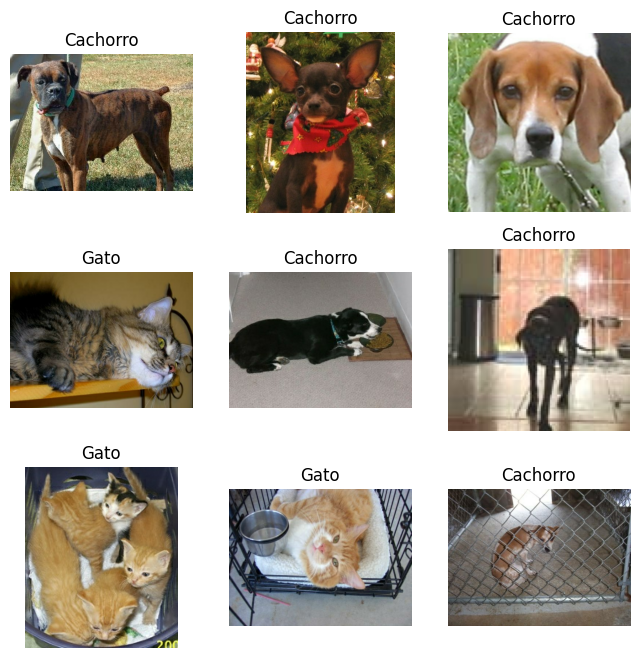

In [ ]:
# ================================================
# PARTE 3 - DISTRIBUIÇÃO E VISUALIZAÇÃO DE AMOSTRAS
# ================================================

cat_count = 0
dog_count = 0

for image, label in tfds.as_numpy(ds_train):
    if label == 0:
        cat_count += 1
    else:
        dog_count += 1

for image, label in tfds.as_numpy(ds_test):
    if label == 0:
        cat_count += 1
    else:
        dog_count += 1

total = cat_count + dog_count
print(f"\n🐱 Total de Gatos: {cat_count}")
print(f"🐶 Total de Cachorros: {dog_count}")
print(f"Total de Imagens: {total}")
print(f"\nDistribuição:")
print(f"Gatos: {cat_count / total:.2%}")
print(f"Cachorros: {dog_count / total:.2%}")

# Visualização de amostras
class_names = ['Gato', 'Cachorro']
plt.figure(figsize=(8, 8))
for i, (image, label) in enumerate(ds_train.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_names[label.numpy()])
    plt.axis('off')
plt.show()


In [ ]:
# ================================================
# PARTE 4 - PRÉ-PROCESSAMENTO DAS IMAGENS
# ================================================

BATCH = 64
AUTOTUNE = tf.data.AUTOTUNE

# Normalização e redimensionamento
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Data augmentation leve
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Aplicando pré-processamento
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(augment, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH).prefetch(AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH).prefetch(AUTOTUNE)


In [ ]:
# ================================================
# PARTE 5 - ARQUITETURA DA REDE NEURAL (MLP)
# ================================================

mlp_model = Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),

    Dense(1, activation='sigmoid')  # saída binária (Gato x Cachorro)
])

mlp_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,459,393 (24.64 MB)

 Trainable params: 6,457,857 (24.63 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
# ================================================
# PARTE 6 - COMPILAÇÃO E TREINAMENTO DO MODELO
# ================================================

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True, monitor='val_loss'
)

history = mlp_model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.5183 - loss: 2.4474 - val_accuracy: 0.5479 - val_loss: 2.1232
Epoch 2/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.5475 - loss: 2.2198 - val_accuracy: 0.5946 - val_loss: 1.9739
Epoch 3/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.5552 - loss: 2.0977 - val_accuracy: 0.6000 - val_loss: 1.8892
Epoch 4/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.5594 - loss: 1.9989 - val_accuracy: 0.6217 - val_loss: 1.7969
Epoch 5/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.5596 - loss: 1.8960 - val_accuracy: 0.6178 - val_loss: 1.7205
Epoch 6/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.5690 - loss: 1.7932 - val_accuracy: 0.6285 - val_loss: 1.6336
Epoch 7/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - accuracy: 0.5731 - loss: 1.7127 - val_accuracy: 0.6242 - val_loss: 1.5650
Epoch 8/30
291/291 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.5790 - loss: 1.6212 -

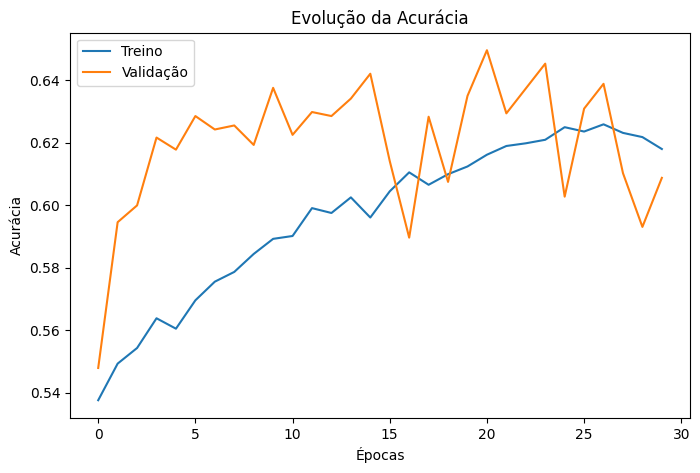

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6053 - loss: 0.8171
Acurácia final no conjunto de teste: 0.6088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━

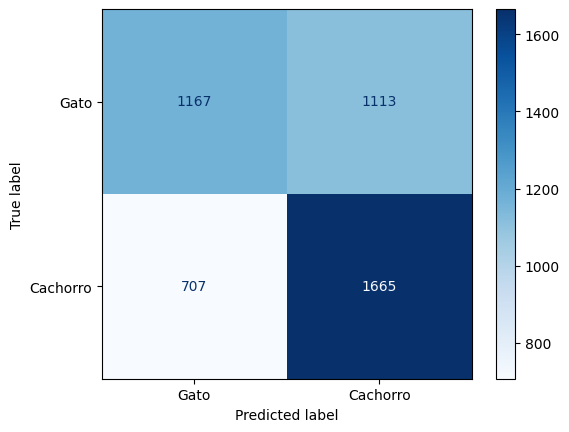


Relatório de Classificação:
              precision    recall  f1-score   support

        Gato       0.62      0.51      0.56      2280
    Cachorro       0.60      0.70      0.65      2372

    accuracy                           0.61      4652
   macro avg       0.61      0.61      0.60      4652
weighted avg       0.61      0.61      0.61      4652



In [ ]:
# ================================================
# PARTE 7 - AVALIAÇÃO DO MODELO E MÉTRICAS
# ================================================

# Curvas de aprendizado
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Avaliação final
test_loss, test_acc = mlp_model.evaluate(ds_test)
print(f"Acurácia final no conjunto de teste: {test_acc:.4f}")

# Matriz de confusão
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = mlp_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Gato', 'Cachorro']).plot(cmap='Blues')
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=['Gato', 'Cachorro']))


-> Matriz de Confusão

- Acertos do modelo:

  - 1167 gatos foram corretamente classificados como gatos.

  - 1665 cachorros foram corretamente classificados como cachorros.

- Erros do modelo:

  - 1113 gatos foram classificados como cachorros.

  - 707 cachorros foram classificados como gatos.


- O modelo está melhor em identificar cachorros do que gatos:

  - Ele acerta 70% dos cachorros (1665 / (1665+707)) ≈ 70,2%

  - Mas acerta apenas 51% dos gatos (1167 / (1167+1113)) ≈ 51,2%

DOCUMENTAÇÃO RESUMIDA:

1️⃣ PRÉ-PROCESSAMENTO
- Imagens redimensionadas para 64x64 e normalizadas (0–1).
- Data Augmentation (flip horizontal e brilho aleatório) melhora generalização.

2️⃣ ARQUITETURA DA RNA
- Rede MLP densa (sem convolução).
- 3 camadas densas com 512 → 256 → 128 neurônios.
- ReLU nas camadas internas e Sigmoid na saída (classificação binária).
- Regularização L2 e Dropout evitam overfitting.

3️⃣ TREINAMENTO
- Otimizador Adam com LR=0.0001.
- EarlyStopping interrompe antes do overfitting.
- Métrica principal: Acurácia.

4️⃣ AVALIAÇÃO
- Curvas de aprendizado analisam overfitting.
- Matriz de confusão e relatório de classificação mostram erros do modelo.

Com essa configuração, esperou-se acurácia entre 0.60,
mantendo a rede puramente MLP (sem CNNs).

Referências principais de documentação:

-> Slides de Redes Neurais, Gemini e ChatGPT